## Nonlinear MPC Following Another Vehicle With Minimum Distance

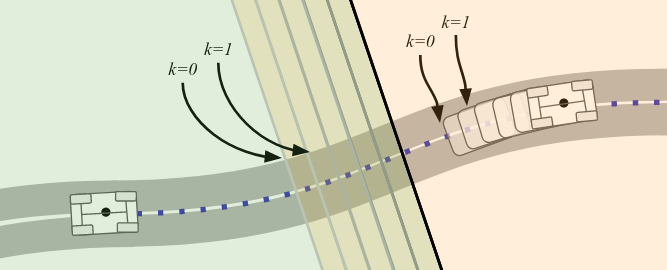

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Set up the road data

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from trajectory_planner import TrajectoryPlanner
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

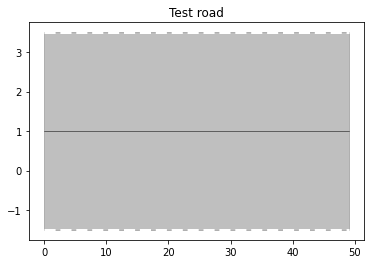

In [2]:
# Generates a straight test_road
test_road = np.ones((50,2))
for i in range(50):
    test_road[i,0] = i

left_width = 2.5*np.ones(np.size(test_road)//2)
right_width = 2.5*np.ones(np.size(test_road)//2)

# Plot the test road
def plot_road(ax, road, left_width, right_width):
    plt.title("Test road")
    ax.plot(road[:,0], road[:,1]+right_width, color="white", linestyle="--", linewidth=3)
    ax.plot(road[:,0], road[:,1]-left_width, color="white", linestyle="--", linewidth=3)
    ax.fill(np.concatenate([road[:,0], np.flip(road[:,0]), road[0:1,0]]),
             np.concatenate([road[:,1]+right_width, np.flip(road[:,1]-left_width), road[0:1,1]+right_width[0:1]]),
            color="grey", alpha=0.5)
    ax.plot(road[:,0], road[:,1], color="black", linewidth=0.5)
    return ax

fig, ax = plt.subplots(1,1)
plot_road(ax, test_road, left_width, right_width)
plt.show()

## Initialize the car and road model

In [3]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
params = {"step":0.075,
          "N":30,
          "n":4, # 4 states
          "m":2, # 2 control inputs
         }
planner = TrajectoryPlanner(**params)

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        left_width  = left_width,
                        right_width = right_width,
                        P           = np.size(left_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

### Set up the desired_speed function

In [5]:
# Speed to start at
DESIRED_SPEED = 4.0

def desired_speed(x, y, k):
    return DESIRED_SPEED

### Set up the driveable_corridor function

In [6]:
def driveable_corridor(x, y, s):
    state = roadrunner.save_state()
    step = roadrunner.advance_xy(np.array([x,y]))
    xy, psi, dl, dr = roadrunner.evaluate(s, full_data=True)
    xy = np.reshape(xy, 2)
    roadrunner.reset(**state)
    return xy[0], xy[1], psi, dl, dr

### Set up the constraint_generator
It returns a function that is <= 0 for safe states

In [7]:
x0_front, y0_front = 12.0, 1.0 # initial position of car ahead
v_front = 3.75 # m/s # car ahead is moving slower than us
minimum_distance = 8.0 # m, minimum distance between cars
step = 0.075 # timestep
def constraint_generator(z, k):
    def g(x, y, v, psi, index):
        x0, y0 = x0_front+(index+k)*step*v_front - minimum_distance, y0_front
        return -((y-y0)**2 + (x-x0)**2)*np.cos(np.arctan2(y0-y, x0-x))
    return g

### Initial conditions

In [8]:
xy, angle, dl, dr = roadrunner.evaluate(full_data=True)
ic = np.array([xy[0,0], xy[0,1], desired_speed(xy[0,0], xy[0,1], 0), angle])
print("Initial conditions: x, y, v, phi =", ic)

Initial conditions: x, y, v, phi = [2.28698896e-20 1.00000000e+00 4.00000000e+00 0.00000000e+00]


## Run the MPC algorithm

### Cost weights

In [9]:
weights = {
       "accuracy":1.0,
           "jerk":100.0,
"steering change":100.0,
       "acceleration":0.0,
}

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 120

## Initialize the trajectory planner

In [10]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(2)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], desired_speed(0, xy[0], xy[1]), roadrunner.get_angle()]

z_est, u_est = planner.generate_first_estimate(ic, driveable_corridor, desired_speed, constraint_generator)
planner.mpcprob.model.state_estimate =z_est
planner.mpcprob.model.control_estimate =u_est

planner.setup_to_save_data(n_runs)

planner.z0 = ic
estimated_path, _, _ = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
planner.initialize_first_mpc_problem(estimated_path)

<IPython.core.display.Javascript object>


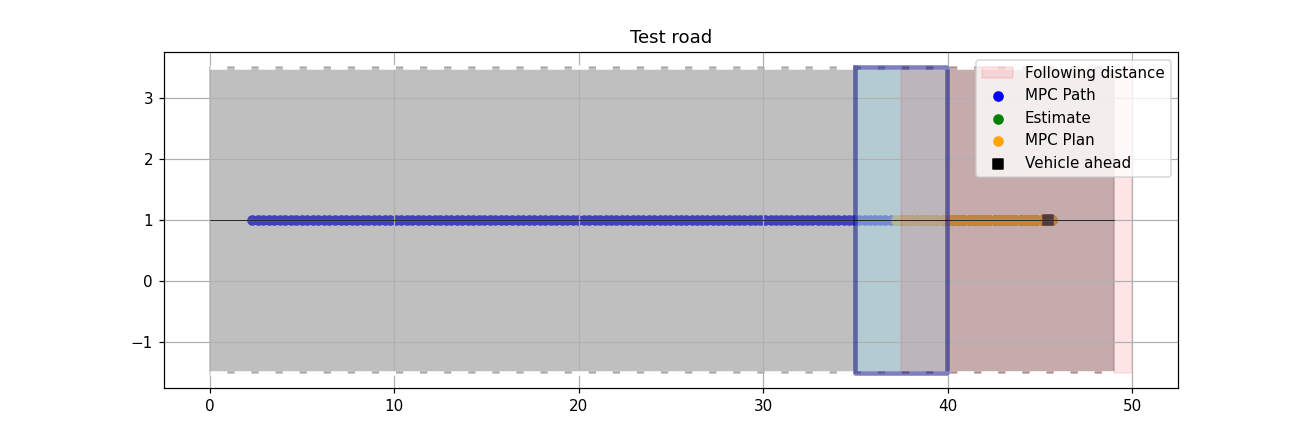


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  27  2.1656765e-01 7.01e-14 2.81e-01  -3.8 1.29e-05    -  1.00e+00 1.00e+00h  1
  28  2.1655609e-01 6.48e-14 2.32e-03  -3.8 1.32e-06    -  1.00e+00 1.00e+00h  1
  29  2.1655648e-01 5.98e-14 1.20e-06  -3.8 4.44e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1643117e-01 6.66e-14 2.39e-01  -5.7 1.10e-04    -  1.00e+00 1.00e+00f  1
  31  2.1641910e-01 8.20e-14 1.66e-03  -5.7 1.37e-06    -  1.00e+00 1.00e+00h  1
  32  2.1641946e-01 8.12e-14 8.39e-07  -5.7 4.17e-08    -  1.00e+00 1.00e+00h  1
  33  2.1641762e-01 5.98e-14 3.73e-05  -8.6 1.37e-06    -  1.00e+00 1.00e+00h  1
  34  2.1641762e-01 4.91e-14 1.69e-10  -8.6 2.05e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   2.1641762302072262e-01    2.1641762302072262e-01
Dual infeasibility......:   1.6876278152722080e-10    1.6876278152722080e-10
Constraint viol

  56  3.8270000e-01 1.90e-08 1.33e+05  -5.7 2.62e-03   1.5 1.00e+00 1.12e-01h  1
  57  3.8059298e-01 3.20e-08 5.47e+00  -5.7 2.29e-04    -  1.00e+00 1.00e+00f  1
  58  3.8150169e-01 6.04e-09 2.99e+00  -5.7 7.89e-05    -  1.00e+00 1.00e+00h  1
  59  3.8176761e-01 7.59e-10 6.91e+02  -5.7 2.40e-05    -  1.00e+00 9.62e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.8177871e-01 5.61e-10 4.74e+03  -5.7 3.85e-06    -  1.00e+00 2.50e-01f  3
  61  3.8181218e-01 7.12e-14 2.80e-02  -5.7 2.90e-06    -  1.00e+00 1.00e+00h  1
  62  3.8181266e-01 7.31e-14 1.34e-05  -5.7 4.12e-08    -  1.00e+00 1.00e+00h  1
  63  3.8181082e-01 6.33e-14 2.83e-05  -8.6 1.44e-06    -  1.00e+00 1.00e+00h  1
  64  3.8181081e-01 6.51e-14 1.18e-10  -8.6 1.18e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   3.8181081497930480e-01    3.8181081497930480e-01
Dual infeas

  57  5.8688717e-01 3.39e-14 7.04e-02  -5.7 1.96e-11    -  1.00e+00 2.44e-04h 13
  58  5.8688717e-01 3.39e-14 7.04e-02  -5.7 1.96e-11    -  1.00e+00 3.81e-06h 19
  59  5.8688717e-01 3.39e-14 7.04e-02  -5.7 1.96e-11    -  1.00e+00 1.91e-06h 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.8688717e-01 9.22e-14 1.36e-10  -5.7 1.96e-11    -  1.00e+00 1.00e+00s 22
  61  5.8688533e-01 7.31e-14 2.30e-05  -8.6 1.51e-06    -  1.00e+00 1.00e+00h  1
  62  5.8688533e-01 6.34e-14 1.88e-10  -8.6 7.84e-11    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:   5.8688533263755005e-01    5.8688533263755005e-01
Dual infeasibility......:   1.8849810601295758e-10    1.8849810601295758e-10
Constraint violation....:   6.3449245857327696e-14    6.3449245857327696e-14
Complementarity.........:   2.5059035601590788e-09    2.5059035601590788e-09
Overall NLP error......

  25  1.1224778e+00 7.81e-14 5.25e-02  -2.5 3.00e-05   3.2 1.00e+00 1.00e+00f  1
  26  1.1224330e+00 7.21e-14 5.28e-02  -2.5 1.13e-05   3.7 1.00e+00 1.00e+00h  1
  27  1.1223268e+00 4.41e-13 5.33e-02  -2.5 3.42e-05   3.2 1.00e+00 1.00e+00f  1
  28  1.1222904e+00 8.68e-14 5.35e-02  -2.5 1.29e-05   3.6 1.00e+00 1.00e+00h  1
  29  1.1222006e+00 3.60e-12 5.37e-02  -2.5 3.88e-05   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1221691e+00 7.33e-13 5.37e-02  -2.5 1.46e-05   3.6 1.00e+00 1.00e+00h  1
  31  1.1220847e+00 1.29e-10 5.36e-02  -2.5 4.36e-05   3.1 1.00e+00 1.00e+00f  1
  32  1.1220390e+00 3.89e-11 7.49e-02  -2.5 2.28e-05   3.5 1.00e+00 1.00e+00h  1
  33  1.1213933e+00 8.54e-08 1.93e+01  -2.5 1.07e-03   3.0 1.00e+00 1.00e+00f  1
  34  1.1063213e+00 4.49e-07 1.72e+00  -2.5 1.78e-02    -  1.00e+00 1.00e+00f  1
  35  1.1084703e+00 5.19e-08 1.57e+04  -2.5 2.43e-03    -  4.84e-01 1.00e+00h  1
  36  1.1121418e+00 2.16e-09

  21  1.4340975e+00 5.87e-14 3.89e-01  -2.5 4.43e-05   3.3 1.00e+00 1.00e+00f  1
  22  1.4322939e+00 1.92e-13 1.22e+00  -2.5 9.08e-05   2.9 1.00e+00 1.00e+00f  1
  23  1.4318624e+00 1.23e-13 2.43e-01  -2.5 2.88e-05   3.3 1.00e+00 1.00e+00h  1
  24  1.4317135e+00 1.14e-13 5.52e-02  -2.5 1.05e-05   3.7 1.00e+00 1.00e+00h  1
  25  1.4313915e+00 1.38e-12 8.75e-02  -2.5 3.23e-05   3.2 1.00e+00 1.00e+00f  1
  26  1.4312874e+00 3.33e-13 5.77e-02  -2.5 1.24e-05   3.7 1.00e+00 1.00e+00h  1
  27  1.4310630e+00 3.39e-11 5.95e-02  -2.5 3.82e-05   3.2 1.00e+00 1.00e+00f  1
  28  1.4309849e+00 1.18e-11 5.97e-02  -2.5 1.44e-05   3.6 1.00e+00 1.00e+00h  1
  29  1.4257948e+00 2.02e-08 3.42e+01  -2.5 1.22e-03   3.1 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4290382e+00 3.73e-09 3.95e+00  -2.5 2.93e-04   2.7 1.00e+00 1.00e+00h  1
  31  1.4116969e+00 3.64e-07 1.10e+01  -2.5 1.98e-02    -  1.00e+00 1.00e+00f  1
  32  1.4150935e+00 3.86e-07

  54  1.7500985e+00 1.31e-09 1.78e+01  -2.5 2.82e-04   3.7 1.00e+00 1.00e+00f  1
  55  1.7476293e+00 9.33e-11 4.78e+00  -2.5 1.20e-03    -  1.00e+00 1.00e+00F  1
  56  1.7459472e+00 1.46e-09 1.12e+01  -2.5 6.50e-04    -  1.00e+00 1.00e+00F  1
  57  1.7457361e+00 1.66e-10 2.60e+03  -2.5 3.22e-03    -  1.00e+00 1.25e-01f  4
  58  1.7449830e+00 5.73e-11 5.87e-02  -2.5 3.22e-05   3.3 1.00e+00 1.00e+00h  1
  59  1.7450173e+00 1.23e-09 6.71e+03  -2.5 3.04e-03    -  9.55e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.7452850e+00 2.76e-10 7.70e-02  -2.5 5.63e-05   2.8 1.00e+00 1.00e+00h  1
  61  1.7452800e+00 1.07e-09 6.56e+03  -2.5 2.67e-03    -  1.00e+00 1.25e-01f  4
  62  1.7441879e+00 2.33e-10 3.11e-02  -2.5 7.26e-05   2.3 1.00e+00 1.00e+00h  1
  63  1.7442732e+00 9.86e-10 6.03e+03  -2.5 5.05e-03    -  6.63e-01 6.25e-02f  5
  64  1.7458748e+00 8.47e-10 1.85e+03  -2.5 2.73e-04   2.7 1.00e+00 2.50e-01f  3
  65  1.7454572e+00 2.27e-09

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.2944926093936466 to [[20.86705476  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  26  4.6515003e+00 6.10e-13 1.04e+00  -2.5 2.43e-05   3.7 1.00e+00 1.00e+00f  1
  27  4.6511823e+00 4.48e-13 3.38e-01  -2.5 9.42e-06   4.1 1.00e+00 1.00e+00f  1
  28  4.6510574e+00 1.54e-13 1.40e-01  -2.5 3.60e-06   4.5 1.00e+00 1.00e+00h  1
  29  4.6506454e+00 6.91e-12 4.80e-01  -2.5 1.13e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.6504739e+00 1.97e-12 1.99e-01  -2.5 5.68e-06   4.5 1.00e+00 1.00e+00f  1
  31  4.6497522e+00 2.38e-10 1.37e+00  -2.5 6.22e-05   4.0 1.00e+00 1.00e+00f  1
  32  4.6494299e+00 2.01e-11 4.64e-01  -2.5 1.77e-05   4.4 1.00e+00 1.00e+00f  1
  33  4.6482022e+00 5.99e-11 4.78e+00  -2.5 3.35e-05   3.9 1.00e+00 1.00e+00f  1
  34  4.6478941e+00 1.75e-12 2.34e-01  -2.5 8.16e-06   4.4 1.00e+00 1.00e+00h  1
  35  4.6462524e+00 9.13e-10 2.20e+01  -2.5 1.25e-04   3.9 1.00e+00 1.00e+00f  1
  36  4.5883364e+00 1.22e-08 1.76e-01  -2.5 3.90e-02    -  1.00e+00 1.00e+00f  1
  37  4.5883882e+00 4.03e-11

  47  5.0368899e+00 6.23e-11 2.53e-01  -2.5 5.58e-05   2.8 1.00e+00 1.00e+00h  1
  48  5.0395070e+00 3.42e-07 1.58e+03  -2.5 2.77e-02    -  7.45e-01 1.00e+00F  1
  49  5.0452863e+00 2.99e-07 4.02e+03  -2.5 1.24e-03   2.4 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.0426589e+00 1.36e-09 4.29e-01  -2.5 1.48e-04   1.9 1.00e+00 1.00e+00h  1
  51  5.0424806e+00 8.97e-08 1.26e+00  -2.5 3.32e-03    -  1.00e+00 1.00e+00f  1
  52  5.0427075e+00 4.38e-09 3.84e-03  -2.5 6.98e-04    -  1.00e+00 1.00e+00h  1
  53  5.0380248e+00 7.07e-07 4.81e+02  -3.8 1.52e-02    -  1.00e+00 6.00e-01f  1
  54  5.0362377e+00 4.37e-07 1.32e+01  -3.8 7.09e-03    -  1.00e+00 1.00e+00f  1
  55  5.0353391e+00 4.41e-08 2.36e+02  -3.8 1.20e-03    -  1.00e+00 9.26e-01h  1
  56  5.0352194e+00 3.89e-08 8.58e+00  -3.8 2.07e-03    -  1.00e+00 1.00e+00f  1
  57  5.0350852e+00 3.44e-08 1.24e+04  -3.8 3.04e-03    -  1.00e+00 2.73e-01h  2
  58  5.0350269e+00 3.73e-08

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  27  6.5901900e+00 5.22e-11 9.35e-01  -2.5 2.90e-05   4.1 1.00e+00 1.00e+00f  1
  28  6.5898421e+00 1.08e-11 4.37e-01  -2.5 1.32e-05   4.5 1.00e+00 1.00e+00f  1
  29  6.5884398e+00 2.38e-10 3.98e+00  -2.5 6.14e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.5879798e+00 4.04e-12 2.96e-01  -2.5 1.00e-05   4.5 1.00e+00 1.00e+00f  1
  31  6.5865666e+00 1.53e-11 2.85e+00  -2.5 3.07e-05   4.0 1.00e+00 1.00e+00f  1
  32  6.5861352e+00 2.34e-11 5.48e-01  -2.5 2.09e-05   4.4 1.00e+00 1.00e+00f  1
  33  6.5842014e+00 1.47e-09 3.23e+01  -2.5 1.57e-04   3.9 1.00e+00 1.00e+00f  1
  34  6.3706377e+00 2.35e-07 3.35e-01  -2.5 7.26e-02    -  1.00e+00 1.00e+00f  1
  35  6.3707950e+00 5.78e-10 1.10e-02  -2.5 3.67e-04    -  1.00e+00 1.00e+00h  1
  36  6.3687902e+00 1.13e-11 1.21e+01  -3.8 4.22e-03    -  1.00e+00 1.00e+00f  1
  37  6.3679476e+00 2.83e-10 1.20e+00  -3.8 8.22e-05    -  1.00e+00 1.00e+00h  1
  38  6.3681516e+00 7.85e-14

  47  6.8110485e+00 1.50e-10 1.05e-01  -3.8 5.51e-05   2.1 1.00e+00 1.00e+00h  1
  48  6.8109704e+00 1.60e-09 1.71e+00  -3.8 2.13e-04   1.6 1.00e+00 1.00e+00h  1
  49  6.8108864e+00 6.06e-10 1.08e+00  -3.8 1.23e-04   2.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.8108276e+00 1.78e-10 3.88e-01  -3.8 6.23e-05   2.5 1.00e+00 1.00e+00h  1
  51  6.8103729e+00 1.80e-08 3.25e+01  -3.8 6.00e-04   2.0 1.00e+00 1.00e+00f  1
  52  6.8001873e+00 1.61e-07 3.52e+02  -3.8 8.64e-04   3.3 1.00e+00 1.00e+00f  1
  53  6.8060762e+00 3.73e-08 4.99e+01  -3.8 4.28e-04   3.7 1.00e+00 1.00e+00h  1
  54  6.8090345e+00 6.39e-09 2.02e+00  -3.8 1.39e-04   4.2 1.00e+00 1.00e+00h  1
  55  6.8065173e+00 2.43e-08 9.80e+01  -3.8 6.24e-04   3.7 1.00e+00 1.00e+00f  1
  56  6.8068628e+00 3.16e-09 1.97e+01  -3.8 4.58e-04    -  1.00e+00 1.00e+00H  1
  57  6.8071306e+00 1.60e-12 9.61e-01  -3.8 9.30e-06    -  1.00e+00 1.00e+00h  1
  58  6.8071569e+00 1.23e-13

Advanced by 0.28850736924279813 to [[23.51148478  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf

  28  8.3015317e+00 7.94e-14 4.42e-01  -2.5 8.29e-06   4.5 1.00e+00 1.00e+00f  1
  29  8.3002611e+00 2.20e-13 2.26e+00  -2.5 2.58e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.2997013e+00 8.80e-14 8.81e-01  -2.5 1.12e-05   4.5 1.00e+00 1.00e+00f  1
  31  8.2968209e+00 2.35e-11 4.32e+00  -2.5 6.02e-05   4.0 1.00e+00 1.00e+00f  1
  32  8.0792443e+00 3.41e-07 9.89e+01  -2.5 7.09e-02    -  1.00e+00 1.00e+00f  1
  33  8.0816566e+00 1.36e-08 2.15e+01  -2.5 4.60e-04   3.5 1.00e+00 1.00e+00h  1
  34  8.0849299e+00 1.94e-10 5.30e+00  -2.5 4.07e-04    -  1.00e+00 1.00e+00H  1
  35  8.0850923e+00 1.72e-12 1.02e+00  -2.5 1.38e-05    -  1.00e+00 1.00e+00h  1
  36  8.0851459e+00 9.72e-14 3.44e-02  -2.5 2.72e-06    -  1.00e+00 1.00e+00h  1
  37  8.0827669e+00 2.21e-12 1.16e+01  -3.8 4.80e-03    -  1.00e+00 1.00e+00f  1
  38  8.0820025e+00 7.75e-11 9.55e-01  -3.8 1.22e-04    -  1.00e+00 1.00e+00h  1
  39  8.0821674e+00 1.08e-13

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  8.4895743e+00 1.44e-08 7.37e+04  -3.8 6.40e-04   3.4 1.00e+00 7.23e-01f  1
  51  8.4878464e+00 5.29e-08 1.04e+01  -3.8 9.37e-04    -  1.00e+00 1.00e+00f  1
  52  8.4888866e+00 8.10e-10 8.62e-01  -3.8 4.61e-05    -  1.00e+00 1.00e+00h  1
  53  8.4892080e+00 3.58e-13 1.89e-01  -3.8 6.85e-06    -  1.00e+00 1.00e+00h  1
  54  8.4892207e+00 1.23e-13 8.88e-04  -3.8 2.72e-07    -  1.00e+00 1.00e+00h  1
  55  8.4890728e+00 8.04e-14 4.33e-02  -5.7 2.91e-04    -  1.00e+00 1.00e+00f  1
  56  8.4890709e+00 7.22e-14 9.95e-06  -5.7 4.88e-07    -  1.00e+00 1.00e+00h  1
  57  8.4890690e+00 7.70e-14 6.60e-06  -8.6 3.63e-06    -  1.00e+00 1.00e+00h  1
  58  8.4890690e+00 8.09e-14 1.28e-09  -8.6 7.56e-11    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   8.4890690187386308e+00    8.4890690187386308e+00
Dual infeas

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Dual infeasibility......:   1.3621388461615425e-09    1.3621388461615425e-09
Constraint violation....:   7.5772721430666934e-14    7.5772721430666934e-14
Complementarity.........:   2.5059035599371090e-09    2.5059035599371090e-09
Overall NLP error.......:   8.7321951676075280e-10    2.5059035599371090e-09


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 34
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w/o function evaluations)   =      0.141
Total CPU secs in NLP function evaluations           =      0.095

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.96ms ( 49.00us)   1.93ms ( 48.17us)

  26  1.0497867e+01 2.41e-13 1.52e+00  -2.5 1.65e-05   4.6 1.00e+00 1.00e+00f  1
  27  1.0489723e+01 9.35e-09 1.92e+02  -2.5 1.59e-04   4.1 1.00e+00 1.00e+00f  1
  28  1.0357429e+01 3.91e-08 9.04e+00  -2.5 5.52e-02    -  1.00e+00 1.00e+00f  1
  29  1.0358774e+01 7.99e-11 1.62e+00  -2.5 5.91e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0358763e+01 3.91e-13 3.68e-02  -2.5 1.41e-04    -  1.00e+00 1.00e+00h  1
  31  1.0355687e+01 2.47e-13 1.09e+01  -3.8 5.86e-03    -  1.00e+00 1.00e+00f  1
  32  1.0355002e+01 1.32e-13 7.40e-01  -3.8 2.24e-04    -  1.00e+00 1.00e+00h  1
  33  1.0355132e+01 1.10e-13 1.48e-02  -3.8 2.54e-06    -  1.00e+00 1.00e+00h  1
  34  1.0355133e+01 1.15e-13 2.85e-06  -3.8 1.29e-08    -  1.00e+00 1.00e+00h  1
  35  1.0354983e+01 1.08e-13 3.90e-02  -5.7 3.51e-04    -  1.00e+00 1.00e+00f  1
  36  1.0354981e+01 7.14e-14 7.45e-06  -5.7 8.28e-07    -  1.00e+00 1.00e+00h  1
  37  1.0354979e+01 9.53e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  19  1.1757878e+01 1.27e-13 2.04e-01  -1.7 8.20e-05   3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1753925e+01 8.98e-14 1.96e-01  -1.7 2.35e-04   2.9 1.00e+00 1.00e+00f  1
  21  1.1738766e+01 1.31e-13 2.97e+00  -2.5 2.62e-04   3.3 1.00e+00 1.00e+00f  1
  22  1.1717744e+01 1.04e-13 5.66e+03  -2.5 6.12e-04   2.9 1.00e+00 6.10e-01f  1
  23  1.1712646e+01 1.06e-13 5.50e+00  -2.5 1.53e-04   3.3 1.00e+00 1.00e+00f  1
  24  1.1707723e+01 1.15e-13 4.55e-01  -2.5 8.65e-05   3.7 1.00e+00 1.00e+00f  1
  25  1.1705815e+01 8.97e-14 7.18e-01  -2.5 3.31e-05   4.1 1.00e+00 1.00e+00f  1
  26  1.1701073e+01 1.35e-13 6.46e+00  -2.5 8.96e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.1699546e+01 8.68e-14 3.44e+00  -2.5 3.11e-05   4.1 1.00e+00 1.00e+00f  1
  28  1.1698850e+01 7.52e-14 6.60e-01  -2.5 1.29e-05   4.5 1.00e+00 1.00e+00f  1
  29  1.1696481e+01 8.07e-14 5.89e+00  -2.5 4.16e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  57  1.1632702e+01 3.88e-08 4.23e+04  -3.8 6.88e-03    -  1.00e+00 1.22e-01h  3
  58  1.1632551e+01 1.25e-12 2.84e-02  -3.8 4.03e-06   2.8 1.00e+00 1.00e+00h  1
  59  1.1632522e+01 1.21e-11 4.11e-03  -3.8 1.35e-05   2.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1632515e+01 5.15e-11 2.19e-02  -3.8 3.56e-05   1.9 1.00e+00 1.00e+00h  1
  61  1.1632495e+01 2.98e-10 1.93e-01  -3.8 1.04e-04   1.4 1.00e+00 1.00e+00h  1
  62  1.1632402e+01 4.01e-09 4.10e+00  -3.8 4.47e-04   0.9 1.00e+00 1.00e+00h  1
  63  1.1632240e+01 4.19e-09 6.89e+00  -3.8 3.95e-04   1.4 1.00e+00 1.00e+00h  1
  64  1.1631781e+01 1.68e-08 3.47e+01  -3.8 6.30e-04   1.8 1.00e+00 1.00e+00h  1
  65  1.1629950e+01 1.78e-08 4.76e+05  -3.8 1.04e-03   3.1 1.00e+00 2.68e-01f  1
  66  1.1625421e+01 3.78e-08 1.02e+01  -3.8 7.51e-04    -  1.00e+00 1.00e+00f  1
  67  1.1626800e+01 1.90e-09 5.42e+00  -3.8 6.65e-05    -  1.00e+00 1.00e+00h  1
  68  1.1627245e+01 7.36e-12

  66  1.1913384e+01 2.11e-08 1.28e+01  -3.8 3.80e-04   4.0 1.00e+00 1.00e+00h  1
  67  1.1908704e+01 5.28e-08 1.12e+02  -3.8 7.43e-04   3.5 1.00e+00 1.00e+00f  1
  68  1.1912236e+01 1.78e-08 4.02e+01  -3.8 4.00e-04    -  1.00e+00 1.00e+00H  1
  69  1.1911675e+01 1.58e-08 1.96e+01  -3.8 2.19e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.1913451e+01 4.22e-09 3.45e+00  -3.8 9.45e-05    -  1.00e+00 1.00e+00h  1
  71  1.1914499e+01 4.24e-12 1.16e+00  -3.8 1.92e-05    -  1.00e+00 1.00e+00h  1
  72  1.1914631e+01 9.86e-14 5.93e-02  -3.8 2.42e-06    -  1.00e+00 1.00e+00h  1
  73  1.1914633e+01 7.94e-14 4.10e-05  -3.8 9.73e-08    -  1.00e+00 1.00e+00h  1
  74  1.1914481e+01 8.80e-14 3.60e-02  -5.7 4.17e-04    -  1.00e+00 1.00e+00f  1
  75  1.1914479e+01 1.18e-13 5.98e-06  -5.7 1.36e-06    -  1.00e+00 1.00e+00h  1
  76  1.1914477e+01 8.57e-14 5.47e-06  -8.6 5.21e-06    -  1.00e+00 1.00e+00h  1
  77  1.1914477e+01 8.74e-14

  51  1.2200599e+01 1.47e-06 4.38e+02  -3.8 2.15e-02    -  1.00e+00 6.12e-01f  1
  52  1.2197247e+01 1.31e-06 2.40e+01  -3.8 1.23e-02    -  1.00e+00 1.00e+00f  1
  53  1.2195986e+01 3.68e-07 1.16e+03  -3.8 1.79e-03    -  1.00e+00 7.33e-01h  1
  54  1.2195586e+01 4.68e-08 1.00e+01  -3.8 2.23e-03    -  1.00e+00 1.00e+00f  1
  55  1.2195423e+01 3.59e-08 5.52e+03  -3.8 2.33e-03    -  1.00e+00 4.49e-01h  2
  56  1.2195353e+01 3.76e-08 3.49e+04  -3.8 6.14e-03    -  1.00e+00 1.39e-01h  3
  57  1.2195207e+01 9.03e-11 3.59e-01  -3.8 4.75e-05   1.5 1.00e+00 1.00e+00h  1
  58  1.2195144e+01 1.06e-09 7.54e-01  -3.8 2.13e-04   1.0 1.00e+00 1.00e+00h  1
  59  1.2194980e+01 1.26e-08 5.87e+04  -3.8 3.72e-03   0.6 1.00e+00 2.24e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2194690e+01 2.64e-09 8.09e+00  -3.8 2.49e-04   1.9 1.00e+00 1.00e+00h  1
  61  1.2194031e+01 1.09e-08 2.91e+01  -3.8 4.15e-04   2.3 1.00e+00 1.00e+00f  1
  62  1.2191331e+01 2.68e-09

  45  1.2636356e+01 2.95e-05 3.40e+01  -1.7 5.61e-02    -  9.13e-01 1.00e+00f  1
  46  1.2642496e+01 1.95e-06 2.28e+00  -1.7 1.35e-02    -  1.00e+00 1.00e+00h  1
  47  1.2634468e+01 1.34e-07 2.77e-02  -1.7 3.84e-03    -  1.00e+00 1.00e+00h  1
  48  1.2534380e+01 1.20e-05 1.23e+02  -3.8 6.78e-02    -  9.79e-01 5.70e-01f  1
  49  1.2481431e+01 2.05e-05 2.58e+01  -3.8 5.01e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.2470715e+01 9.44e-06 6.62e+02  -3.8 1.42e-02    -  1.00e+00 5.67e-01h  1
  51  1.2461889e+01 5.45e-07 1.29e+01  -3.8 7.59e-03    -  1.00e+00 1.00e+00f  1
  52  1.2459993e+01 1.33e-07 8.30e+00  -3.8 3.74e-03    -  1.00e+00 1.00e+00h  1
  53  1.2459442e+01 7.57e-08 8.82e+00  -3.8 2.86e-03    -  1.00e+00 1.00e+00h  1
  54  1.2459069e+01 3.48e-08 9.65e+00  -3.8 1.94e-03    -  1.00e+00 1.00e+00h  1
  55  1.2458936e+01 6.03e-08 3.48e+01  -3.8 2.56e-03    -  1.00e+00 1.00e+00h  1
  56  1.2458319e+01 2.90e-08

  60  1.2708229e+01 2.39e-10 7.02e-01  -3.8 6.10e-05   4.1 1.00e+00 1.00e+00f  1
  61  1.2701386e+01 6.02e-08 1.02e+04  -3.8 7.75e-04   3.6 1.00e+00 9.62e-01f  1
  62  1.2702342e+01 4.59e-08 5.12e+04  -3.8 3.34e-04   4.0 1.00e+00 2.50e-01f  3
  63  1.2700117e+01 3.49e-08 9.76e+01  -3.8 7.53e-04   3.5 1.00e+00 1.00e+00f  1
  64  1.2704654e+01 3.67e-09 1.34e+01  -3.8 3.77e-04    -  1.00e+00 1.00e+00H  1
  65  1.2705552e+01 9.33e-13 5.21e-01  -3.8 1.60e-05    -  1.00e+00 1.00e+00h  1
  66  1.2705628e+01 9.54e-14 3.53e-03  -3.8 1.36e-06    -  1.00e+00 1.00e+00h  1
  67  1.2705475e+01 7.41e-14 3.42e-02  -5.7 4.60e-04    -  1.00e+00 1.00e+00f  1
  68  1.2705473e+01 9.23e-14 5.29e-06  -5.7 1.79e-06    -  1.00e+00 1.00e+00h  1
  69  1.2705471e+01 1.17e-13 5.25e-06  -8.6 5.74e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2705471e+01 1.07e-13 1.94e-09  -8.6 2.80e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

  61  1.2950788e+01 1.00e-08 3.37e+00  -3.8 3.69e-04   2.7 1.00e+00 1.00e+00f  1
  62  1.2949040e+01 1.43e-08 5.43e+02  -3.8 4.47e-04   3.2 1.00e+00 9.97e-01f  1
  63  1.2945863e+01 2.37e-09 1.53e+01  -3.8 2.57e-04    -  1.00e+00 1.00e+00f  1
  64  1.2946612e+01 1.27e-12 2.39e+00  -3.8 1.32e-05    -  1.00e+00 1.00e+00h  1
  65  1.2946646e+01 1.45e-13 3.70e-02  -3.8 2.65e-06    -  1.00e+00 1.00e+00h  1
  66  1.2946648e+01 8.07e-14 2.49e-05  -3.8 1.28e-07    -  1.00e+00 1.00e+00h  1
  67  1.2946493e+01 1.13e-13 3.41e-02  -5.7 4.74e-04    -  1.00e+00 1.00e+00f  1
  68  1.2946492e+01 1.16e-13 5.23e-06  -5.7 1.96e-06    -  1.00e+00 1.00e+00h  1
  69  1.2946490e+01 8.57e-14 5.18e-06  -8.6 5.92e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2946490e+01 1.29e-13 8.85e-11  -8.6 3.06e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objecti

  65  1.3181692e+01 7.73e-09 9.93e+04  -3.8 1.52e-03   1.8 1.00e+00 2.66e-01f  2
  66  1.3181131e+01 7.68e-10 4.96e+00  -3.8 9.93e-05   3.1 1.00e+00 1.00e+00h  1
  67  1.3180621e+01 5.74e-10 2.76e+00  -3.8 9.03e-05   3.5 1.00e+00 1.00e+00f  1
  68  1.3180186e+01 1.97e-10 7.16e-01  -3.8 5.41e-05   4.0 1.00e+00 1.00e+00f  1
  69  1.3176715e+01 1.69e-08 6.22e+05  -3.8 1.82e-03   3.5 1.00e+00 2.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.3173584e+01 7.59e-08 3.35e+01  -3.8 1.12e-03    -  1.00e+00 1.00e+00f  1
  71  1.3175175e+01 6.48e-09 6.39e+00  -3.8 1.26e-04    -  1.00e+00 1.00e+00h  1
  72  1.3176660e+01 3.63e-10 1.31e+00  -3.8 2.60e-05    -  1.00e+00 1.00e+00h  1
  73  1.3176905e+01 1.49e-13 1.53e-01  -3.8 4.29e-06    -  1.00e+00 1.00e+00h  1
  74  1.3176911e+01 1.25e-13 2.50e-04  -3.8 1.63e-07    -  1.00e+00 1.00e+00h  1
  75  1.3176756e+01 8.94e-14 3.37e-02  -5.7 4.88e-04    -  1.00e+00 1.00e+00f  1
  76  1.3176754e+01 9.81e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.2845234623128671 to [[29.26371397  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_

  26  1.4488764e+01 2.45e-13 2.13e-01  -1.7 4.55e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.4487248e+01 4.90e-12 2.12e-01  -1.7 1.36e-04   3.2 1.00e+00 1.00e+00f  1
  28  1.4486684e+01 8.74e-13 2.12e-01  -1.7 5.11e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.4485021e+01 2.08e-11 2.12e-01  -1.7 1.53e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4484401e+01 3.81e-12 2.11e-01  -1.7 5.72e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.4482562e+01 1.14e-10 2.10e-01  -1.7 1.71e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.4481872e+01 2.18e-11 2.10e-01  -1.7 6.40e-05   3.5 1.00e+00 1.00e+00f  1
  33  1.4479739e+01 1.71e-09 2.08e-01  -1.7 1.91e-04   3.0 1.00e+00 1.00e+00f  1
  34  1.4478726e+01 4.34e-10 2.21e-01  -1.7 7.59e-05   3.5 1.00e+00 1.00e+00f  1
  35  1.4471630e+01 8.74e-08 8.88e+00  -1.7 1.07e-03   3.0 1.00e+00 1.00e+00f  1
  36  1.4439478e+01 5.89e-08 1.25e+01  -1.7 1.10e-03   2.5 1.00e+00 1.00e+00f  1
  37  1.4140043e+01 1.08e-06

  21  1.4662821e+01 1.29e-12 2.11e-01  -1.7 9.53e-05   3.3 1.00e+00 1.00e+00f  1
  22  1.4662407e+01 2.14e-13 2.11e-01  -1.7 3.57e-05   3.8 1.00e+00 1.00e+00f  1
  23  1.4661213e+01 3.44e-12 2.11e-01  -1.7 1.07e-04   3.3 1.00e+00 1.00e+00f  1
  24  1.4660772e+01 5.82e-13 2.11e-01  -1.7 4.02e-05   3.7 1.00e+00 1.00e+00f  1
  25  1.4659489e+01 1.04e-11 2.11e-01  -1.7 1.20e-04   3.2 1.00e+00 1.00e+00f  1
  26  1.4659012e+01 1.79e-12 2.11e-01  -1.7 4.51e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.4657614e+01 3.64e-11 2.10e-01  -1.7 1.35e-04   3.2 1.00e+00 1.00e+00f  1
  28  1.4657093e+01 6.47e-12 2.10e-01  -1.7 5.06e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.4655546e+01 1.55e-10 2.09e-01  -1.7 1.51e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4654960e+01 2.83e-11 2.09e-01  -1.7 5.66e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.4653073e+01 1.96e-09 2.07e-01  -1.7 1.68e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.4652142e+01 4.42e-10

  26  1.4760675e+01 2.70e-11 9.75e+00  -2.5 9.70e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.4758880e+01 7.09e-11 6.16e+00  -2.5 3.42e-05   4.1 1.00e+00 1.00e+00f  1
  28  1.4757766e+01 1.54e-11 5.80e-01  -2.5 1.75e-05   4.5 1.00e+00 1.00e+00f  1
  29  1.4753147e+01 1.02e-10 1.98e+01  -2.5 7.42e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4752251e+01 7.39e-11 1.90e+00  -2.5 3.70e-05   4.5 1.00e+00 1.00e+00f  1
  31  1.4750332e+01 7.08e-10 1.54e+01  -2.5 1.10e-04   4.0 1.00e+00 1.00e+00f  1
  32  1.4360068e+01 2.10e-07 1.52e+03  -2.5 9.41e-02    -  1.00e+00 9.62e-01f  1
  33  1.4394766e+01 3.27e-08 6.85e+00  -2.5 2.85e-02    -  1.00e+00 1.00e+00f  1
  34  1.4362015e+01 4.99e-09 3.99e+00  -2.5 2.47e-02    -  1.00e+00 1.00e+00f  1
  35  1.4358658e+01 1.09e-10 3.84e-01  -2.5 5.35e-03    -  1.00e+00 1.00e+00h  1
  36  1.4358642e+01 9.61e-14 8.81e-05  -2.5 2.32e-05    -  1.00e+00 1.00e+00h  1
  37  1.4352797e+01 1.03e-13

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  28  1.5864018e+01 1.87e-13 2.86e-01  -1.7 6.90e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.5860577e+01 5.47e-12 2.86e-01  -1.7 2.07e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5859318e+01 1.07e-12 2.86e-01  -1.7 7.76e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.5855706e+01 4.45e-11 2.86e-01  -1.7 2.33e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.5854373e+01 8.98e-12 2.86e-01  -1.7 8.72e-05   3.5 1.00e+00 1.00e+00f  1
  33  1.5850467e+01 7.19e-10 2.85e-01  -1.7 2.61e-04   3.0 1.00e+00 1.00e+00f  1
  34  1.5848944e+01 1.51e-10 2.84e-01  -1.7 9.73e-05   3.5 1.00e+00 1.00e+00f  1
  35  1.5787298e+01 1.18e-06 1.17e+02  -1.7 4.78e-03   3.0 1.00e+00 1.00e+00F  1
  36  1.5817666e+01 5.44e-08 1.20e+01  -1.7 1.17e-03   2.5 1.00e+00 1.00e+00h  1
  37  1.5231059e+01 6.90e-06 1.34e+03  -1.7 7.13e-02    -  8.87e-01 1.00e+00f  1
  38  1.5324348e+01 2.38e-08 1.05e+01  -1.7 1.52e-03   2.0 1.00e+00 1.00e+00f  1
  39  1.5259658e+01 1.44e-07

  27  1.5668647e+01 3.14e-13 7.32e+00  -2.5 4.48e-05   4.1 1.00e+00 1.00e+00f  1
  28  1.5667089e+01 1.74e-13 3.22e+00  -2.5 2.43e-05   4.5 1.00e+00 1.00e+00f  1
  29  1.5666403e+01 1.23e-13 9.58e-01  -2.5 1.08e-05   4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5663570e+01 1.67e-11 4.70e+01  -2.5 4.53e-05   4.5 1.00e+00 1.00e+00f  1
  31  1.5246277e+01 8.13e-08 1.51e+04  -2.5 9.97e-02    -  1.00e+00 8.95e-01f  1
  32  1.5280833e+01 9.55e-09 6.19e+00  -2.5 2.47e-02    -  1.00e+00 1.00e+00f  1
  33  1.5242758e+01 3.99e-10 4.27e+00  -2.5 2.60e-02    -  1.00e+00 1.00e+00f  1
  34  1.5238046e+01 6.22e-11 5.65e-01  -2.5 6.47e-03    -  1.00e+00 1.00e+00h  1
  35  1.5238004e+01 1.13e-13 3.81e-04  -2.5 6.22e-05    -  1.00e+00 1.00e+00h  1
  36  1.5230937e+01 1.82e-13 6.47e+02  -5.7 1.01e-02    -  9.97e-01 1.00e+00f  1
  37  1.5230311e+01 1.73e-10 3.12e+03  -5.7 1.20e-03    -  1.00e+00 9.01e-01h  1
  38  1.5230365e+01 1.09e-13

Number of Lagrangian Hessian evaluations             = 68
Total CPU secs in IPOPT (w/o function evaluations)   =      0.270
Total CPU secs in NLP function evaluations           =      0.194

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.29ms ( 45.69us)   3.30ms ( 45.78us)        72
       nlp_g  |  18.83ms (261.53us)  18.83ms (261.54us)        72
  nlp_grad_f  |   5.07ms ( 72.37us)   4.96ms ( 70.79us)        70
  nlp_hess_l  |  81.94ms (  1.20ms)  81.83ms (  1.20ms)        68
   nlp_jac_g  |  83.79ms (  1.20ms)  83.71ms (  1.20ms)        70
       total  | 465.03ms (465.03ms) 460.55ms (460.55ms)         1
u_opt [-0.02022184832285164, 4.4459817719875744e-17]
Advanced by 0.2805395553829388 to [[32.38518006  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     

  26  1.6288031e+01 1.17e-13 2.99e-01  -1.7 5.11e-04   2.8 1.00e+00 1.00e+00f  1
  27  1.6278604e+01 1.11e-13 5.51e-01  -1.7 1.88e-04   3.2 1.00e+00 1.00e+00f  1
  28  1.6275335e+01 9.12e-14 2.84e-01  -1.7 6.83e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.6267758e+01 2.30e-13 5.95e-01  -1.7 1.88e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6265282e+01 1.10e-13 2.50e-01  -1.7 6.78e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.6259629e+01 1.89e-12 2.74e-01  -1.7 2.09e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.6257756e+01 4.36e-13 2.62e-01  -1.7 7.97e-05   3.5 1.00e+00 1.00e+00f  1
  33  1.6253273e+01 2.13e-11 2.67e-01  -1.7 2.44e-04   3.0 1.00e+00 1.00e+00f  1
  34  1.6251729e+01 4.85e-12 2.68e-01  -1.7 9.21e-05   3.5 1.00e+00 1.00e+00f  1
  35  1.6247713e+01 9.06e-10 2.70e-01  -1.7 2.78e-04   3.0 1.00e+00 1.00e+00f  1
  36  1.6246132e+01 3.16e-10 2.68e-01  -1.7 1.03e-04   3.4 1.00e+00 1.00e+00f  1
  37  1.6245521e+01 5.80e-11

  28  1.6587746e+01 1.13e-13 4.08e-01  -1.7 8.74e-05   3.7 1.00e+00 1.00e+00f  1
  29  1.6581085e+01 7.52e-14 3.86e-01  -1.7 2.48e-04   3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6578811e+01 9.44e-14 3.77e-01  -1.7 9.07e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.6573126e+01 2.34e-13 3.60e-01  -1.7 2.60e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.6571144e+01 9.35e-14 3.53e-01  -1.7 9.57e-05   3.6 1.00e+00 1.00e+00f  1
  33  1.6565923e+01 2.11e-12 3.41e-01  -1.7 2.77e-04   3.1 1.00e+00 1.00e+00f  1
  34  1.6564054e+01 4.49e-13 3.37e-01  -1.7 1.03e-04   3.5 1.00e+00 1.00e+00f  1
  35  1.6558865e+01 4.47e-11 3.27e-01  -1.7 2.99e-04   3.0 1.00e+00 1.00e+00f  1
  36  1.6556969e+01 9.92e-12 3.24e-01  -1.7 1.11e-04   3.5 1.00e+00 1.00e+00f  1
  37  1.6556265e+01 1.61e-12 3.23e-01  -1.7 4.15e-05   3.9 1.00e+00 1.00e+00f  1
  38  1.6554191e+01 2.40e-11 3.20e-01  -1.7 1.24e-04   3.4 1.00e+00 1.00e+00f  1
  39  1.6553418e+01 3.98e-12

  26  2.0876073e+01 1.16e-13 2.06e+00  -1.0 2.82e-02   1.9 1.00e+00 1.00e+00f  1
  27  2.0545599e+01 1.07e-13 1.83e+00  -1.0 9.40e-03   2.3 1.00e+00 1.00e+00f  1
  28  1.9831093e+01 1.22e-13 1.37e+00  -1.0 2.11e-02   1.8 1.00e+00 1.00e+00f  1
  29  1.9610456e+01 1.14e-13 1.25e+00  -1.0 7.20e-03   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9125740e+01 5.18e-13 1.00e+00  -1.0 1.74e-02   1.8 1.00e+00 1.00e+00f  1
  31  1.8974522e+01 1.10e-13 9.18e-01  -1.0 5.97e-03   2.2 1.00e+00 1.00e+00f  1
  32  1.8379990e+01 6.69e-13 5.10e+02  -1.7 2.27e-02   1.7 1.00e+00 5.94e-01f  1
  33  1.8095484e+01 5.50e-12 9.44e+00  -1.7 8.15e-03   2.1 1.00e+00 1.00e+00f  1
  34  1.7955969e+01 8.40e-13 3.28e+00  -1.7 3.29e-03   2.6 1.00e+00 1.00e+00f  1
  35  1.7908525e+01 3.29e-13 2.56e+00  -1.7 1.18e-03   3.0 1.00e+00 1.00e+00f  1
  36  1.7800339e+01 7.36e-10 9.20e+00  -1.7 3.17e-03   2.5 1.00e+00 1.00e+00f  1
  37  1.7775564e+01 2.61e-09

  28  3.1588981e+01 9.80e-14 6.69e+00  -1.0 1.29e-02   2.7 1.00e+00 1.00e+00f  1
  29  2.9423118e+01 7.88e-13 5.67e+00  -1.0 3.27e-02   2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.8712666e+01 1.22e-13 5.31e+00  -1.0 1.15e-02   2.7 1.00e+00 1.00e+00f  1
  31  2.6987399e+01 3.82e-12 4.47e+00  -1.0 2.91e-02   2.2 1.00e+00 1.00e+00f  1
  32  2.6419356e+01 5.63e-13 4.18e+00  -1.0 1.02e-02   2.6 1.00e+00 1.00e+00f  1
  33  2.5035249e+01 1.54e-11 3.51e+00  -1.0 2.57e-02   2.1 1.00e+00 1.00e+00f  1
  34  2.4578591e+01 2.29e-12 3.28e+00  -1.0 9.00e-03   2.6 1.00e+00 1.00e+00f  1
  35  2.3464811e+01 5.55e-11 2.75e+00  -1.0 2.26e-02   2.1 1.00e+00 1.00e+00f  1
  36  2.3097012e+01 8.41e-12 2.56e+00  -1.0 7.91e-03   2.5 1.00e+00 1.00e+00f  1
  37  2.2200743e+01 1.91e-10 2.14e+00  -1.0 1.98e-02   2.0 1.00e+00 1.00e+00f  1
  38  2.1904767e+01 2.92e-11 2.01e+00  -1.0 6.97e-03   2.5 1.00e+00 1.00e+00f  1
  39  2.1185283e+01 6.40e-10

  28  1.1952443e+02 2.41e-13 3.06e+01  -1.0 7.38e-03   3.6 1.00e+00 1.00e+00f  1
  29  1.1586107e+02 4.55e-12 2.93e+01  -1.0 2.11e-02   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1453150e+02 7.92e-13 2.87e+01  -1.0 7.79e-03   3.6 1.00e+00 1.00e+00f  1
  31  1.1075928e+02 1.69e-11 2.74e+01  -1.0 2.22e-02   3.1 1.00e+00 1.00e+00f  1
  32  1.0939324e+02 2.92e-12 2.68e+01  -1.0 8.18e-03   3.5 1.00e+00 1.00e+00f  1
  33  1.0553173e+02 6.98e-11 2.54e+01  -1.0 2.33e-02   3.0 1.00e+00 1.00e+00f  1
  34  1.0413666e+02 1.20e-11 2.49e+01  -1.0 8.55e-03   3.5 1.00e+00 1.00e+00f  1
  35  1.0020844e+02 3.20e-10 2.35e+01  -1.0 2.42e-02   3.0 1.00e+00 1.00e+00f  1
  36  9.8792804e+01 5.49e-11 2.30e+01  -1.0 8.89e-03   3.4 1.00e+00 1.00e+00f  1
  37  9.4822982e+01 1.62e-09 2.17e+01  -1.0 2.51e-02   2.9 1.00e+00 1.00e+00f  1
  38  9.3396062e+01 2.78e-10 2.12e+01  -1.0 9.18e-03   3.4 1.00e+00 1.00e+00f  1
  39  8.9411656e+01 8.98e-09

  28  2.6227132e+02 7.95e-14 5.76e+01  -1.0 1.39e-02   3.6 1.00e+00 1.00e+00f  1
  29  2.5164123e+02 1.28e-13 5.46e+01  -1.0 3.95e-02   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4782247e+02 9.35e-14 5.35e+01  -1.0 1.45e-02   3.6 1.00e+00 1.00e+00f  1
  31  2.4641308e+02 9.58e-14 5.31e+01  -1.0 5.40e-03   4.0 1.00e+00 1.00e+00f  1
  32  2.4230011e+02 1.02e-13 5.20e+01  -1.0 1.58e-02   3.5 1.00e+00 1.00e+00f  1
  33  2.4078411e+02 1.10e-13 5.15e+01  -1.0 5.89e-03   3.9 1.00e+00 1.00e+00f  1
  34  2.3637021e+02 3.32e-13 5.03e+01  -1.0 1.72e-02   3.5 1.00e+00 1.00e+00f  1
  35  2.3474573e+02 1.01e-13 4.98e+01  -1.0 6.41e-03   3.9 1.00e+00 1.00e+00f  1
  36  2.3002784e+02 1.35e-12 4.85e+01  -1.0 1.87e-02   3.4 1.00e+00 1.00e+00f  1
  37  2.2829430e+02 2.38e-13 4.80e+01  -1.0 6.95e-03   3.8 1.00e+00 1.00e+00f  1
  38  2.2327346e+02 6.51e-12 4.66e+01  -1.0 2.02e-02   3.4 1.00e+00 1.00e+00f  1
  39  2.2143184e+02 1.17e-12

  21  4.0167352e+02 1.59e-13 1.25e+02  -1.0 5.64e-02   3.3 1.00e+00 1.00e+00f  1
  22  3.5558137e+02 1.30e-13 9.86e+01  -1.0 1.33e-01   2.9 1.00e+00 1.00e+00f  1
  23  3.0258436e+02 1.30e-13 2.24e+03  -1.0 2.60e-01   2.4 1.00e+00 5.84e-01f  1
  24  2.7236419e+02 1.20e-13 6.42e+01  -1.0 9.77e-02   2.8 1.00e+00 1.00e+00f  1
  25  2.6211660e+02 1.04e-13 6.23e+01  -1.0 3.56e-02   3.2 1.00e+00 1.00e+00f  1
  26  2.3627983e+02 1.48e-13 5.52e+01  -1.0 9.46e-02   2.8 1.00e+00 1.00e+00f  1
  27  2.2758298e+02 1.37e-13 5.26e+01  -1.0 3.38e-02   3.2 1.00e+00 1.00e+00f  1
  28  2.2444150e+02 9.88e-14 5.17e+01  -1.0 1.25e-02   3.6 1.00e+00 1.00e+00f  1
  29  2.1561693e+02 4.45e-12 4.91e+01  -1.0 3.55e-02   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1243973e+02 1.12e-12 4.82e+01  -1.0 1.31e-02   3.6 1.00e+00 1.00e+00f  1
  31  2.1126624e+02 1.87e-13 4.78e+01  -1.0 4.86e-03   4.0 1.00e+00 1.00e+00f  1
  32  2.0783730e+02 2.92e-12

Advanced by 0.2830874330989949 to [[34.65020482  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_

  99  1.6217934e+01 1.05e-13 2.81e-02  -5.7 7.94e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6217933e+01 1.16e-13 3.56e-06  -5.7 8.87e-06    -  1.00e+00 1.00e+00h  1
 101  1.6217931e+01 9.55e-14 4.23e-06  -8.6 1.01e-05    -  1.00e+00 1.00e+00h  1
 102  1.6217931e+01 1.26e-13 2.20e-10  -8.6 1.43e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:   1.6217931326306051e+01    1.6217931326306051e+01
Dual infeasibility......:   2.1956481077722856e-10    2.1956481077722856e-10
Constraint violation....:   1.2562173523633646e-13    1.2562173523633646e-13
Complementarity.........:   2.5059035694775161e-09    2.5059035694775161e-09
Overall NLP error.......:   6.8771444968776855e-10    2.5059035694775161e-09


Number of objective function evaluations             = 134
Number of objective gradient evaluations      

  62  1.6287032e+01 5.06e-08 3.36e+02  -5.7 4.89e-04   3.2 1.00e+00 1.00e+00f  1
  63  1.6285349e+01 3.85e-08 1.72e+02  -5.7 7.08e-04   3.6 1.00e+00 1.00e+00f  1
  64  1.6290887e+01 3.66e-09 2.97e+01  -5.7 3.22e-04    -  1.00e+00 1.00e+00H  1
  65  1.6291792e+01 3.46e-10 2.26e+00  -5.7 1.76e-05    -  1.00e+00 1.00e+00h  1
  66  1.6291898e+01 3.39e-12 1.94e-02  -5.7 3.61e-06    -  1.00e+00 1.00e+00h  1
  67  1.6291901e+01 1.35e-13 4.49e-06  -5.7 6.15e-08    -  1.00e+00 1.00e+00h  1
  68  1.6291899e+01 7.33e-14 4.20e-06  -8.6 1.02e-05    -  1.00e+00 1.00e+00h  1
  69  1.6291899e+01 9.29e-14 1.61e-09  -8.6 1.49e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:   1.6291899313349127e+01    1.6291899313349127e+01
Dual infeasibility......:   1.6074181985459290e-09    1.6074181985459290e-09
Constraint violation....:   9.2925667161125602e-14    9.2925667161125602e-14
Complementarity....

  56  1.6621471e+01 1.10e-04 1.82e+01  -2.5 1.21e-01    -  1.00e+00 1.00e+00f  1
  57  1.6482144e+01 5.16e-05 1.24e+02  -2.5 6.08e-02    -  1.00e+00 6.51e-01f  1
  58  1.6406175e+01 8.75e-06 1.35e+01  -2.5 3.17e-02    -  1.00e+00 1.00e+00f  1
  59  1.6390765e+01 3.05e-07 1.98e+00  -2.5 5.50e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.6389868e+01 2.77e-08 1.60e-01  -2.5 1.72e-03    -  1.00e+00 1.00e+00h  1
  61  1.6389757e+01 1.50e-11 2.00e-04  -2.5 4.05e-05    -  1.00e+00 1.00e+00h  1
  62  1.6377453e+01 2.24e-06 3.37e+02  -3.8 2.62e-02    -  1.00e+00 6.28e-01f  1
  63  1.6371573e+01 2.38e-06 2.71e+01  -3.8 1.68e-02    -  1.00e+00 1.00e+00f  1
  64  1.6369738e+01 7.79e-07 1.19e+03  -3.8 3.40e-03    -  1.00e+00 6.95e-01h  1
  65  1.6368970e+01 4.71e-08 8.08e+00  -3.8 2.21e-03    -  1.00e+00 1.00e+00f  1
  66  1.6368701e+01 1.93e-08 5.76e+00  -3.8 1.44e-03    -  1.00e+00 1.00e+00h  1
  67  1.6368580e+01 2.58e-08

  64  1.6435154e+01 5.19e-09 2.59e+00  -5.7 6.53e-04   0.4 1.00e+00 1.00e+00f  1
  65  1.6434933e+01 7.73e-08 8.94e+04  -5.7 1.23e-02  -0.0 1.00e+00 2.03e-01h  1
  66  1.6428747e+01 6.67e-09 7.92e+01  -5.7 3.10e-04   3.1 1.00e+00 1.00e+00f  1
  67  1.6426017e+01 1.74e-08 3.07e+01  -5.7 4.90e-04    -  1.00e+00 1.00e+00f  1
  68  1.6427665e+01 4.48e-09 4.44e+00  -5.7 9.64e-05    -  1.00e+00 1.00e+00h  1
  69  1.6428823e+01 3.93e-10 8.87e-01  -5.7 1.83e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.6428947e+01 1.30e-13 4.01e-02  -5.7 1.96e-06    -  1.00e+00 1.00e+00h  1
  71  1.6428949e+01 1.22e-13 1.17e-05  -5.7 3.41e-08    -  1.00e+00 1.00e+00h  1
  72  1.6428947e+01 1.37e-13 4.16e-06  -8.6 1.05e-05    -  1.00e+00 1.00e+00h  1
  73  1.6428947e+01 1.36e-13 1.24e-09  -8.6 1.62e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objecti

  65  1.6498792e+01 8.59e-11 2.10e-01  -3.8 6.09e-05   0.9 1.00e+00 1.00e+00h  1
  66  1.6498772e+01 5.22e-10 3.66e-01  -3.8 2.05e-04   0.4 1.00e+00 1.00e+00h  1
  67  1.6498692e+01 4.97e-09 3.22e+04  -3.8 3.90e-03  -0.1 1.00e+00 1.63e-01h  3
  68  1.6498446e+01 5.50e-08 5.77e+01  -3.8 2.00e-03   0.3 1.00e+00 1.00e+00h  1
  69  1.6495564e+01 4.36e-08 2.48e+05  -3.8 3.11e-04   3.5 1.00e+00 2.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.6485093e+01 6.75e-08 1.05e+02  -3.8 3.43e-04    -  1.00e+00 1.00e+00f  1
  71  1.6456454e+01 1.00e-06 3.72e+02  -3.8 1.68e-03    -  1.00e+00 1.00e+00f  1
  72  1.6485324e+01 2.23e-07 1.31e+01  -3.8 5.72e-04   3.9 1.00e+00 1.00e+00h  1
  73  1.6497709e+01 1.33e-08 1.20e+01  -3.8 1.95e-04   4.3 1.00e+00 1.00e+00h  1
  74  1.6498509e+01 4.55e-10 6.14e+00  -3.8 1.05e-04   3.9 1.00e+00 1.00e+00h  1
  75  1.6498511e+01 3.07e-10 2.19e-01  -3.8 9.17e-05   3.4 1.00e+00 1.00e+00f  1
  76  1.6498456e+01 3.38e-10

  64  1.6602117e+01 1.35e-05 1.39e+01  -2.5 4.10e-02    -  1.00e+00 1.00e+00f  1
  65  1.6581241e+01 8.71e-07 4.14e+00  -2.5 9.91e-03    -  1.00e+00 1.00e+00h  1
  66  1.6581174e+01 3.51e-09 6.44e-02  -2.5 5.93e-04    -  1.00e+00 1.00e+00h  1
  67  1.6581009e+01 4.03e-11 2.26e-04  -2.5 6.55e-05    -  1.00e+00 1.00e+00h  1
  68  1.6568306e+01 2.29e-06 3.31e+02  -3.8 2.65e-02    -  1.00e+00 6.29e-01f  1
  69  1.6562211e+01 2.45e-06 2.71e+01  -3.8 1.70e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.6560328e+01 8.03e-07 1.17e+03  -3.8 3.54e-03    -  1.00e+00 6.96e-01h  1
  71  1.6559537e+01 4.74e-08 7.97e+00  -3.8 2.22e-03    -  1.00e+00 1.00e+00f  1
  72  1.6559270e+01 1.83e-08 5.32e+00  -3.8 1.40e-03    -  1.00e+00 1.00e+00h  1
  73  1.6559163e+01 1.70e-08 7.49e+00  -3.8 1.36e-03    -  1.00e+00 1.00e+00h  1
  74  1.6559108e+01 6.20e-12 3.19e-02  -3.8 1.23e-05   1.6 1.00e+00 1.00e+00h  1
  75  1.6559108e+01 2.14e-11

Number of equality constraint Jacobian evaluations   = 71
Number of inequality constraint Jacobian evaluations = 71
Number of Lagrangian Hessian evaluations             = 70
Total CPU secs in IPOPT (w/o function evaluations)   =      0.257
Total CPU secs in NLP function evaluations           =      0.203

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.73ms ( 48.49us)   3.76ms ( 48.87us)        77
       nlp_g  |  20.87ms (271.03us)  21.01ms (272.80us)        77
  nlp_grad_f  |   5.21ms ( 72.35us)   5.16ms ( 71.68us)        72
  nlp_hess_l  |  84.39ms (  1.21ms)  84.26ms (  1.20ms)        70
   nlp_jac_g  |  87.59ms (  1.22ms)  87.57ms (  1.22ms)        72
       total  | 465.56ms (465.56ms) 461.28ms (461.28ms)         1
u_opt [-0.008834893390756346, -1.0591862724172256e-17]
Advanced by 0.2830874330989949 to [[36.62672333  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear s

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [11]:
%matplotlib notebook

# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+params["N"],4,2))

# Set up for plotting
fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(planner.x_true[0], planner.x_true[1], color="red")[0]
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0

try:
    while k < n_runs:

        estimated_path, left_widths, right_widths = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
        
        # Solve the MPC problem
        problem = planner.build_mpc_problem(estimated_path, left_widths, right_widths, weights, constraint_generator(planner.z0, k))
        xk_opt, uk_opt, sol = planner.solve_mpc_problem(problem)
        
        # for plotting
        planner.centers[:,k+1] = planner.mpcprob.x_center_plot[:,1]

        # Save the next state x_k+1 and control u_k+1
        for i in range(params["n"]):
            planner.x_plan[i,k+1] = xk_opt[i][1]
        for i in range(params["m"]):
            planner.u_plan[i,k] = uk_opt[i][1]
        _,p = planner.mpcprob.bound_x(estimated_path[0,0], estimated_path[1,0], estimated_path[3,0], left_widths[0], right_widths[0])
        planner.polygon_boundaries[k,:,:] = p
        
        planner.x_true[:,k+1] = planner.apply_control(planner.u_plan[:,k])
        planner.z0 = planner.x_true[:,k+1]
        
        planner.initialize_nth_mpc_problem(xk_opt, uk_opt)
    
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(planner.x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())

        # for plotting
        ax_traj.clear()
        plot_road(ax_traj, test_road, left_width, right_width)
        
        # Plot the MPC car's current position
        ax_traj.scatter(planner.x_true[0,:k], planner.x_true[1,:k], color="blue", label="MPC Path")
        
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        # Plot the polygon fill
        ax_traj.fill(planner.polygon_boundaries[k,:,0], planner.polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([planner.polygon_boundaries[k,:,0],planner.polygon_boundaries[k,0:1,0]]),
                np.concatenate([planner.polygon_boundaries[k,:,1],planner.polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)
        
        # Plot the estimated path (helps with debugging)
        ax_traj.scatter(estimated_path[0,:], estimated_path[1,:], color="green", label="Estimate")
        
        # Plot the planned path
        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange", label="MPC Plan")
        
        # Plot the car ahead
        x_front, y_front = x0_front+(k)*step*v_front, y0_front
        ax_traj.scatter(x_front, y_front, color="black", marker="s", s=50, label="Vehicle ahead")
        # Plot the keep-out region (minimum distance from vehicle)
        min_x = x_front-minimum_distance
        ax_traj.fill(np.array([min_x, min_x, 50, 50, min_x]), np.array([-1.5, 3.5, 3.5, -1.5, -1.5]), alpha=0.1, color="red",label="Following distance")
        plt.legend()
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1

except OutOfRoadPointsException as e:
    print(e)

finally:
    planner.x_plan = planner.x_plan[:,:k] # Cut the vectors shorter so they don't have unitialized values
    planner.u_plan = planner.u_plan[:,:k-2]  
    planner.x_true = planner.x_true[:,k]
    planner.centers = planner.centers[:,k]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
    fig_traj.canvas.draw()

In [31]:
# turn interactive plotting off
plt.ioff()

## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


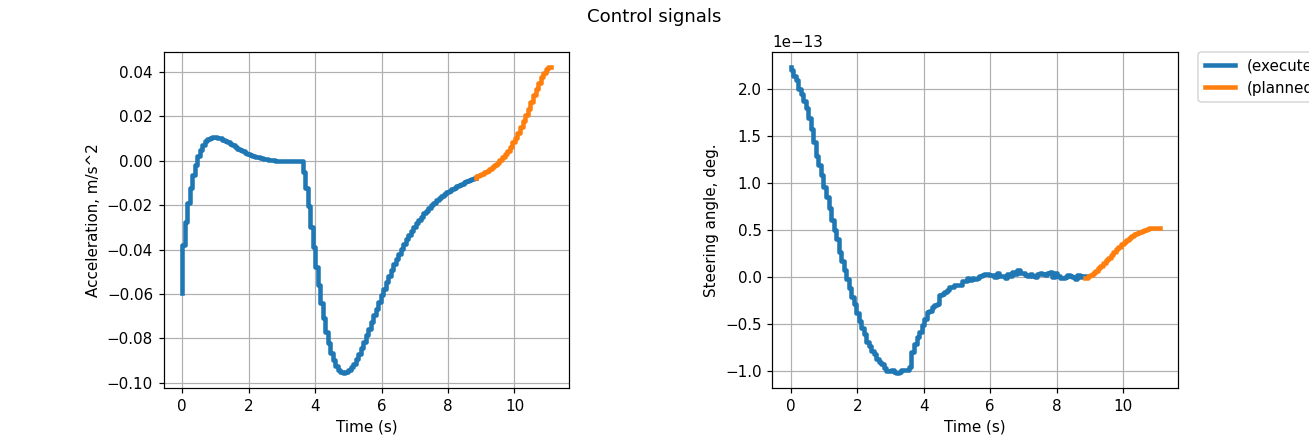

In [32]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(planner.u_plan, planner.mpcprob.u_opt, params["step"], params["N"])

plt.show()

<IPython.core.display.Javascript object>


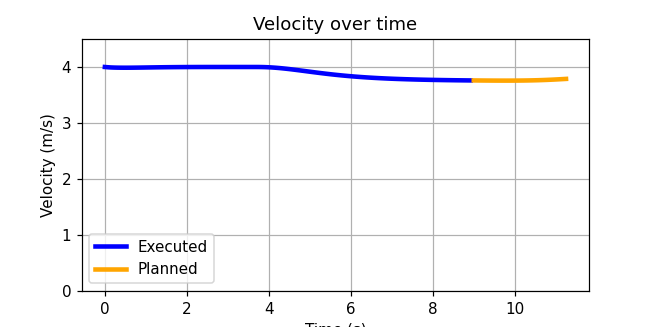

In [56]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.plot(np.arange(np.size(planner.x_plan[2,:k]))*planner.step, planner.x_plan[2,:k], color="blue", label="Executed")
ax.plot(np.arange(np.size(planner.mpcprob.x_opt[2,:]))*planner.step + np.size(planner.x_plan[2,:])*planner.step, planner.mpcprob.x_opt[2,:], color="orange", label="Planned")
plt.ylim(0, 4.5)
plt.legend()
plt.ylabel("Velocity (m/s)"); plt.xlabel("Time (s)")
plt.title("Velocity over time")
plt.show()
plt.savefig("vehicle_following_velocity.pdf")

<IPython.core.display.Javascript object>


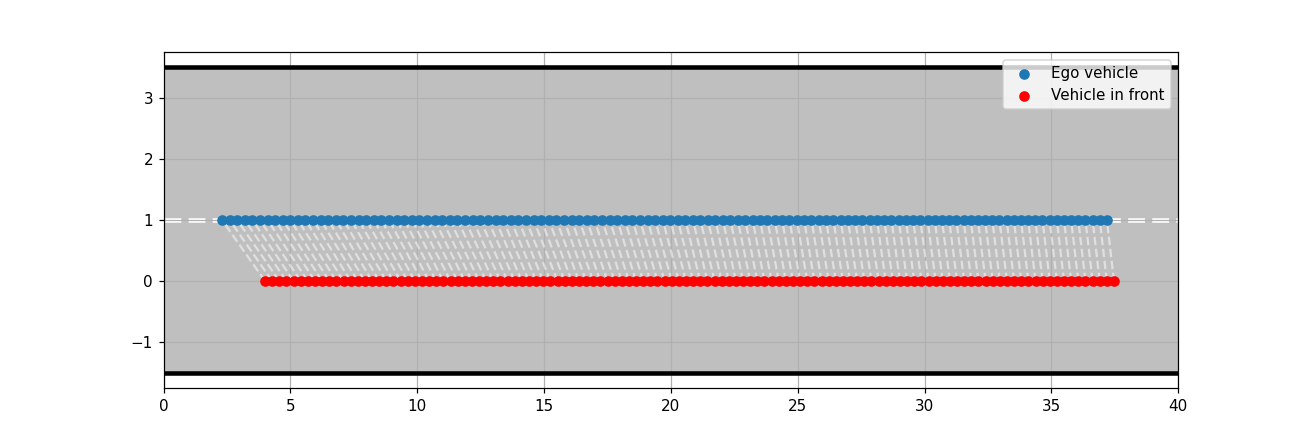

In [52]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.xlim(0, 40)
ax.plot(test_road[:,0], test_road[:,1]+right_width, color="black")
ax.plot(test_road[:,0], test_road[:,1]-left_width, color="black")
ax.fill(np.concatenate([test_road[:,0], np.flip(test_road[:,0]), test_road[0:1,0]]),
         np.concatenate([test_road[:,1]+right_width, np.flip(test_road[:,1]-left_width), test_road[0:1,1]+right_width[0:1]]),
        color="grey", alpha=0.5, zorder=0)
ax.plot(test_road[:,0], test_road[:,1], linestyle="--", color="white", zorder=1)

ax.scatter(planner.x_plan[0,:], planner.x_plan[1,:], zorder=4, label="Ego vehicle")

# generate the path of the front vehicle
front_vehicle = np.zeros((2,np.shape(planner.x_plan)[1]))
for i in range(front_vehicle.shape[1]):
    x0, y0 = x0_front+i*step*v_front - minimum_distance, y0_front
    front_vehicle[0,i] = x0
    front_vehicle[1,i] = y0


ax.scatter(front_vehicle[0,:], front_vehicle[1,:]-1.0, color="red", zorder=3, label="Vehicle in front")

for i in range(front_vehicle.shape[1]):
    ax.plot([front_vehicle[0,i], planner.x_plan[0,i]], [front_vehicle[1,i]-1.0, planner.x_plan[1,i]], color="white", alpha=0.5, linewidth=1.5, linestyle="--", zorder=2)
    
plt.show()
plt.legend()
plt.savefig("vehicle_following.pdf")